# How much effort would it take to jump between West Hall and East Hall?

Mellie Zito and Annie Tor

ModSim Section 1, Group 13

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question

As Olin students, we have often contemplated odd hypotheticals. In this case, we are going to launch a student from the roof of West Hall to the roof of East Hall. This question was inspired by the frigid, long (1 minute) walk from one dorm to another. For the launch to be as efficient as possible and successful, we need to find the optimal angle and minimum starting velocity needed.

## Model

### Setup

units stuff?

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree;

For the State, 

In [3]:
params = Params(x = 0 * m, #original x position
                y = 12.2 * m, #original y position (12.2 is the height of the edge of West Hall)
                g = 9.8 * m/s**2, #acceleration due to gravity
                mass = 70 * kg, #average mass of a human adult
                diameter = 0.711 * m, #average diameter of a balled-up human (based off Annie)
                rho = 1.2 * kg/m**3, #density of air 
                C_d = 0.47, #drag coefficient of a sphere
                angle = 45 * degree, #initial launch angle
                velocity = 40 * m / s, #initial launch velocity
                t_end = 20 * s) #point at which to end the simulation

,values
x,0 meter
y,12.2 meter
g,9.8 meter / second ** 2
mass,70 kilogram
diameter,0.711 meter
rho,1.2 kilogram / meter ** 3
C_d,0.47
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [5]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [6]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

### Maximum Range and Height based on Angle

In [7]:
system = make_system(params)

,values
x,0 meter
y,12.2 meter
g,9.8 meter / second ** 2
mass,70 kilogram
diameter,0.711 meter
rho,1.2 kilogram / meter ** 3
C_d,0.47
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [8]:
def event_func_range (state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y - 15.74 * m

event_func_range.direction = -1
event_func_range(system.init, 0, system)

<Quantity(-3.540000000000001, 'meter')>

In [9]:
def event_func_height(state, t, system):
    """Stop when the x coordinate is 94.5m.
    
    state: State object
    t: time
    system: System object
    
    returns: x coordinate - 94.5m
    """
    x, y, vx, vy = state
    return x - 19 * m #final x is 18.71, but we want to ensure they land on the roof, and not before it

event_func_height(system.init, 0, system)

<Quantity(-19, 'meter')>

In [10]:
def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params_height = Params(params, angle=angle)
    system_height = make_system(params_height)
    results, details = run_ode_solver(system_height, slope_func, events=event_func_height)
    y_dist = get_last_value(results.y) * m
    return y_dist

height_func(45 * degree, params)

<Quantity(28.92605959694371, 'meter')>

In [11]:
def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params_range = Params(params, angle=angle)
    system_range = make_system(params_range)
    results, details = run_ode_solver(system_range, slope_func, events=event_func_range)
    x_dist = get_last_value(results.x) * m
    return x_dist

range_func(45 * degree, params)

<Quantity(133.3105526017006, 'meter')>

In [12]:
angles = linspace(0, 68, 30)
sweep_range = SweepSeries()
sweep_height = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    sweep_range[angle] = x_dist
    
for angle in angles:
    y_dist = height_func(angle, params)
    sweep_height[angle] = y_dist

Saving figure to file figs/OlinLaunch-fig01.pdf


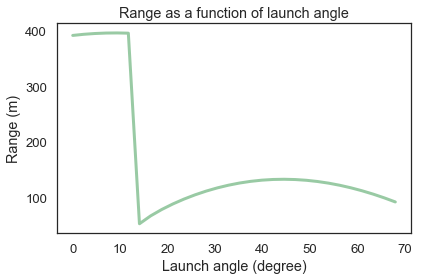

In [13]:
plot(sweep_range, color = 'C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

savefig('figs/OlinLaunch-fig01.pdf')

Saving figure to file figs/OlinLaunch-fig02.pdf


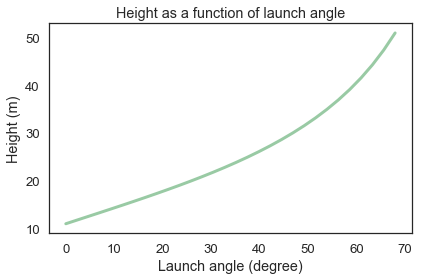

In [14]:
plot(sweep_height, color = 'C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Height (m)',
         title='Height as a function of launch angle',
         legend=False)

savefig('figs/OlinLaunch-fig02.pdf')

In [42]:
results_range = max_bounded(range_func, [0, 90], params)
optimal_angle = results_range.x
print(optimal_angle, results_range.fun)

# results_height = max_bounded(height_func, [0, 90], params)
# optimal_angle = results_height.x
# print(optimal_angle, results_height.fun)

44.383520474811235 133.3402263522255 meter


With initial velocity 40 m/s and an optimal launch angle, the person soars over the wall. Next we figure out the minimum velocity needed.

### Finding the minimum velocity

In [43]:
params_min = Params(x = 0 * m, #original x position
                y = 12.2 * m, #original y position (12.2 is the height of the edge of West Hall)
                g = 9.8 * m/s**2, #acceleration due to gravity
                mass = 70 * kg, #average mass of a human adult
                diameter = 0.711 * m, #average diameter of a balled-up human (based off Annie)
                rho = 1.2 * kg/m**3, #density of air 
                C_d = 0.47, #drag coefficient of a sphere
                angle = results_range.x * degree, #initial launch angle
                velocity = 40 * m / s, #initial launch velocity
                t_end = 20 * s) #point at which to end the simulation

,values
x,0 meter
y,12.2 meter
g,9.8 meter / second ** 2
mass,70 kilogram
diameter,0.711 meter
rho,1.2 kilogram / meter ** 3
C_d,0.47
angle,44.383520474811235 degree
velocity,40.0 meter / second
t_end,20 second


In [44]:
def error_func_velocity(v, params_min):
    params_min.velocity = v * m/s
    system = make_system(params_min)
    results = max_bounded(height_func, [0, 90], params_min)
    height = results.fun
    return height - 16 * m

Test your error function before you call `fsolve`.

In [45]:
error_func_velocity(40, params_min)

<Quantity(67.39117542397085, 'meter')>

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [46]:
min_v_array = fsolve(error_func_velocity, 40, params_min)
min_v = min_v_array[0]

15.267840874900601

And just to check, run `error_func` with the value you found.

In [47]:
error_func_velocity(min_v, params_min)

<Quantity(-3.2294167340296553e-12, 'meter')>

## Results

After finding the optimal angle and minimum starting velocity, we made used those values for angle and velocity in final params. Final params will then be used to run one last simulation for the Oliner Launch, to see if these values would have the correct trajectory.

In [48]:
params_final = Params(x = 0 * m, 
                y = 12.2 * m,
                g = 9.8 * m/s**2, 
                mass = 70 * kg, 
                diameter = 0.711 * m,
                rho = 1.2 * kg/m**3, 
                C_d = 0.47, 
                angle = optimal_angle * degree, 
                velocity = min_v * m / s, 
                t_end = 20 * s);

In [49]:
system_final = make_system(params_final);

The final event func stops the simulation when the Oliner hits the roof of East Hall, which is 15.74 meters tall.

In [50]:
def event_func_final(state, t, system):
    """Stop when the y coordinate is 15.74.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y - 15.74 * m

The event func has its direction set to -1 to make sure the launch is not stopped on the Oliner's way up, but only when they are landing. run_ode_solver is run with the final event_func and system and then the trajectory of the Oliner is plotted (their x and y position).

Saving figure to file figs/OlinLaunch-fig02.pdf


,values
sol,None
t_events,[[1.7470732545185184]]
nfev,1064
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


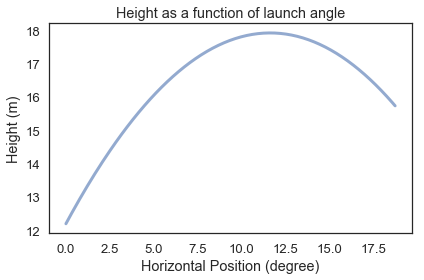

In [51]:
event_func_final.direction = -1
results, details = run_ode_solver(system_final, slope_func, events=event_func_final, max_step=0.01)
plot(results.x, results.y)
decorate(xlabel='Horizontal Position (degree)',
         ylabel='Height (m)',
         title='Height as a function of launch angle',
         legend=False)

savefig('figs/OlinLaunch-fig02.pdf')

details

In [52]:
final_x = get_last_value(results.x)
final_y = get_last_value(results.y)
print(final_x, final_y)

18.735689540213258 15.74


As shown by the graph and the final x and y position of the Oliner, the launch trajectory is correct. With an optimal angle of 50.44 degrees and a minimum velocity of 15.27 m/s, the Oliner lands 0.5 meters past the required horizontal distance (18.71m) and on the roof of East Hall (15.74m).

## Interpretation